In [2]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports réussis !")


✅ Imports réussis !


In [3]:
df = pd.read_csv('../data/processed/dataset_cv_preprocessed.csv')

print(f"📊 Dataset chargé : {len(df)} lignes")
display(df.head())


📊 Dataset chargé : 54 lignes


,ID,CV,Email,Téléphone,Code_Postal,Permis,Diplôme,Langues,Secteur_Activité,Mots,...,Liste_Compétences,Departement,Ratio_Comp_Mots,Densite_Competences,A_Email,A_Telephone,A_Permis,Nb_Langues,Nb_Comp_Tech,Categorie_Longueur
0,2,CV10.pdf,Non trouvé,0668114063,93600.0,Non,Master,Anglais; Français,Informatique/Tech,494.0,...,r; scikit; scikit-learn; gestion; machine lear...,93,0.014141,1.417004,0,1,0,2,1,Moyen
1,4,CV12.pdf,Melvine.moubeyi@aivancity.education,0758328589,94230.0,Non,Bachelor,Anglais; Français,Informatique/Tech,398.0,...,nlp; gcp; pandas; machine learning; français; ...,94,0.060150,6.030151,1,1,0,2,4,Moyen
2,5,CV13.pdf,Non trouvé,+33779457896,94200.0,Non,Master,Anglais; Français,Informatique/Tech,340.0,...,matplotlib; seaborn; r; tensorflow; css; scipy...,94,0.049853,5.000000,0,1,0,2,5,Moyen
3,6,CV14.pdf,mouketoudielowen@gmail.com,0619412532,94200.0,Permis A; Permis D,Baccalauréat,Anglais; Français,Informatique/Tech,554.0,...,etl; pytorch; hadoop; nlp; aws; office; spark;...,94,0.064865,6.498195,1,1,1,2,9,Moyen
4,7,CV15.pdf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Inconnu,0.000000,0.000000,1,1,1,1,0,Court


In [4]:
print("\n📊 ANALYSE DU DÉSÉQUILIBRE DES CLASSES")
print("=" * 80)

df_model = df[
    (df['Secteur_Activité'] != 'Non identifié') & 
    (df['Secteur_Activité'] != 'NA') &
    (df['Secteur_Activité'].notna())
].copy()

secteur_counts = df_model['Secteur_Activité'].value_counts()
print("\n📋 Distribution des secteurs :")
print(secteur_counts)

max_count = secteur_counts.max()
min_count = secteur_counts.min()
ratio = max_count / min_count

print(f"\n⚠️ DÉSÉQUILIBRE : {ratio:.1f}:1")



📊 ANALYSE DU DÉSÉQUILIBRE DES CLASSES

📋 Distribution des secteurs :
Secteur_Activité
Informatique/Tech          16
Marketing/Communication     7
BTP/Construction            6
Finance/Banque              6
Conseil/Audit               4
Commerce/Vente              3
Ressources Humaines         3
Éducation/Formation         2
Transport/Logistique        2
Juridique/Droit             1
Industrie/Production        1
Name: count, dtype: int64

⚠️ DÉSÉQUILIBRE : 16.0:1


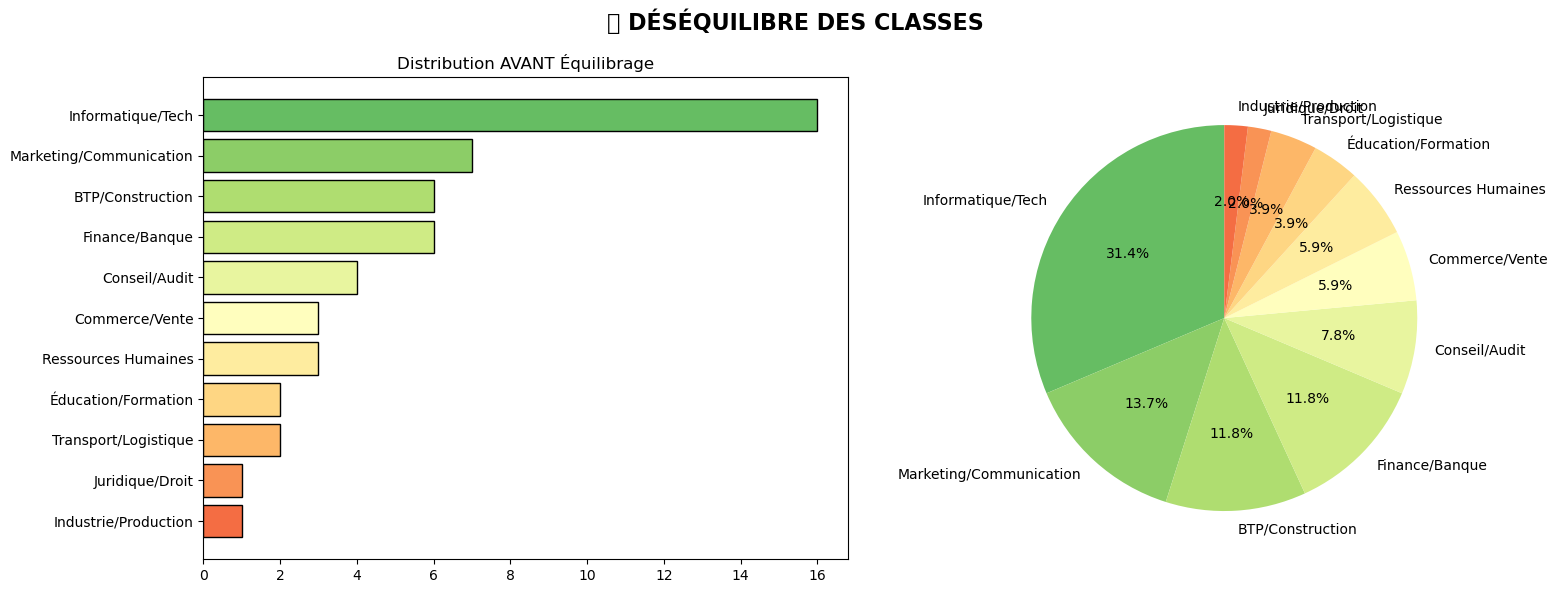

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('📊 DÉSÉQUILIBRE DES CLASSES', fontsize=16, fontweight='bold')

colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(secteur_counts)))

bars = axes[0].barh(secteur_counts.index, secteur_counts.values,
                    color=colors, edgecolor='black')
axes[0].set_title('Distribution AVANT Équilibrage')
axes[0].invert_yaxis()

axes[1].pie(secteur_counts.values, labels=secteur_counts.index,
            autopct='%1.1f%%', startangle=90, colors=colors)

plt.tight_layout()
plt.show()


In [7]:
secteur_mapping = {
    'Informatique/Tech': 'Tech',
    'Finance/Banque': 'Business',
    'Commerce/Vente': 'Business',
    'Marketing/Communication': 'Business',
    'Conseil/Audit': 'Business',
    'Ressources Humaines': 'Services',
    'Juridique/Droit': 'Services',
    'Éducation/Formation': 'Services',
    'Santé/Médical': 'Santé',
    'Industrie/Production': 'Industrie',
    'BTP/Construction': 'Industrie',
    'Transport/Logistique': 'Industrie',
    'Hôtellerie/Restauration': 'Tourisme',
    'Agriculture/Environnement': 'Environnement'
}

df_model['Secteur_Regroupe'] = df_model['Secteur_Activité'].map(secteur_mapping)
secteur_regroupe_counts = df_model['Secteur_Regroupe'].value_counts()

new_ratio = secteur_regroupe_counts.max() / secteur_regroupe_counts.min()
print(f"📈 Ratio après regroupement : {new_ratio:.1f}:1")


📈 Ratio après regroupement : 3.3:1


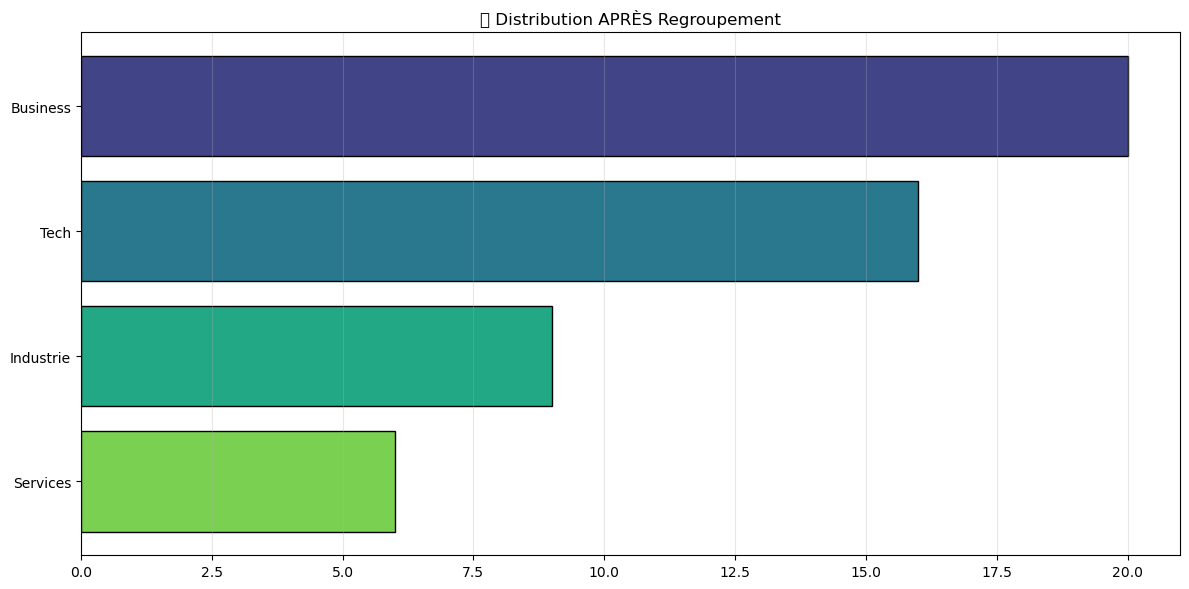

In [8]:
plt.figure(figsize=(12, 6))
bars = plt.barh(
    secteur_regroupe_counts.index,
    secteur_regroupe_counts.values,
    color=plt.cm.viridis(np.linspace(0.2, 0.8, len(secteur_regroupe_counts))),
    edgecolor='black'
)

plt.title('📊 Distribution APRÈS Regroupement')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


In [11]:
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE

# Features
features = [
    f for f in [
        'Mots', 'Compétences', 'Nb_Langues',
        'Nb_Comp_Tech', 'Ratio_Tech', 'Niveau_Diplome',
        'A_Email', 'A_Telephone', 'A_Permis'
    ] if f in df_model.columns
]

X = df_model[features].fillna(0)
y = df_model['Secteur_Regroupe']

# Split stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 🔍 Analyse des classes dans le train
class_counts = Counter(y_train)
min_samples = min(class_counts.values())

print("📊 Distribution des classes (train) :")
for k, v in class_counts.items():
    print(f" - {k:<15} : {v} échantillons")

# ⚠️ Ajustement automatique de k_neighbors
k_neighbors = max(1, min(5, min_samples - 1))

print(f"\n🔧 k_neighbors utilisé pour SMOTE : {k_neighbors}")

# SMOTE robuste
smote = SMOTE(
    random_state=42,
    k_neighbors=k_neighbors
)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\n✅ SMOTE appliqué avec succès")
print(f"   → Avant : {len(X_train)} échantillons")
print(f"   → Après : {len(X_train_balanced)} échantillons")


📊 Distribution des classes (train) :
 - Industrie       : 7 échantillons
 - Business        : 16 échantillons
 - Services        : 5 échantillons
 - Tech            : 12 échantillons

🔧 k_neighbors utilisé pour SMOTE : 4

✅ SMOTE appliqué avec succès
   → Avant : 40 échantillons
   → Après : 64 échantillons


In [14]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier
)
from sklearn.metrics import accuracy_score, f1_score


In [15]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM (RBF)": SVC(kernel="rbf", probability=True),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "GaussianNB": GaussianNB(),
    "BalancedRandomForest": RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
}


In [19]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# =========================
# 1. ÉVALUATION SANS SMOTE
# =========================
results_sans_smote = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results_sans_smote[name] = {
        "Accuracy_sans": accuracy_score(y_test, y_pred),
        "F1_sans": f1_score(y_test, y_pred, average="weighted")
    }

# =========================
# 2. ÉVALUATION AVEC SMOTE
# =========================
results_avec_smote = {}

for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)

    results_avec_smote[name] = {
        "Accuracy_avec": accuracy_score(y_test, y_pred),
        "F1_avec": f1_score(y_test, y_pred, average="weighted")
    }

# =========================
# 3. DATAFRAME FINAL PRO
# =========================
df_comparaison = (
    pd.DataFrame(results_sans_smote)
    .T
    .join(pd.DataFrame(results_avec_smote).T)
)

# =========================
# 4. GAINS DE PERFORMANCE
# =========================
df_comparaison["Δ Accuracy"] = df_comparaison["Accuracy_avec"] - df_comparaison["Accuracy_sans"]
df_comparaison["Δ F1-score"] = df_comparaison["F1_avec"] - df_comparaison["F1_sans"]

# =========================
# 5. MISE EN FORME
# =========================
df_comparaison = (
    df_comparaison
    .reset_index()
    .rename(columns={"index": "Modèle"})
    .round(4)
    .sort_values(by="Δ F1-score", ascending=False)
    .reset_index(drop=True)
)

df_comparaison


,Modèle,Accuracy_sans,F1_sans,Accuracy_avec,F1_avec,Δ Accuracy,Δ F1-score
0,GaussianNB,0.0909,0.1455,0.2727,0.2263,0.1818,0.0808
1,AdaBoost,0.5455,0.5299,0.5455,0.5541,0.0000,0.0242
2,KNN,0.4545,0.3879,0.3636,0.4026,-0.0909,0.0147
3,DecisionTree,0.5455,0.5100,0.4545,0.4571,-0.0909,-0.0529
4,LogisticRegression,0.4545,0.4935,0.3636,0.3521,-0.0909,-0.1414
5,ExtraTrees,0.6364,0.6208,0.4545,0.4646,-0.1818,-0.1561
6,GradientBoosting,0.5455,0.5100,0.2727,0.3232,-0.2727,-0.1868
7,RandomForest,0.6364,0.5541,0.2727,0.3333,-0.3636,-0.2208
8,BalancedRandomForest,0.6364,0.5541,0.2727,0.3333,-0.3636,-0.2208
9,SVM (RBF),0.5455,0.4662,0.1818,0.2424,-0.3636,-0.2238


In [36]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import clone

# =========================
# CONFIG NORMALISATIONS
# =========================
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler()
}

all_results = []

# =========================
# BOUCLE NORMALISATION
# =========================
for scaler_name, scaler in scalers.items():

    # --- Normalisation SANS SMOTE ---
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    results_sans_smote = {}

    for name, model in models.items():
        clf = clone(model)
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)

        results_sans_smote[name] = {
            "Accuracy_sans": accuracy_score(y_test, y_pred),
            "F1_sans": f1_score(y_test, y_pred, average="weighted")
        }

    # --- Normalisation AVEC SMOTE ---
    X_train_bal_scaled = scaler.fit_transform(X_train_balanced)
    X_test_bal_scaled = scaler.transform(X_test)

    results_avec_smote = {}

    for name, model in models.items():
        clf = clone(model)
        clf.fit(X_train_bal_scaled, y_train_balanced)
        y_pred = clf.predict(X_test_bal_scaled)

        results_avec_smote[name] = {
            "Accuracy_avec": accuracy_score(y_test, y_pred),
            "F1_avec": f1_score(y_test, y_pred, average="weighted")
        }

    # --- Fusion résultats ---
    df_tmp = (
        pd.DataFrame(results_sans_smote)
        .T
        .join(pd.DataFrame(results_avec_smote).T)
    )

    df_tmp["Δ Accuracy"] = df_tmp["Accuracy_avec"] - df_tmp["Accuracy_sans"]
    df_tmp["Δ F1-score"] = df_tmp["F1_avec"] - df_tmp["F1_sans"]
    df_tmp["Normalisation"] = scaler_name

    all_results.append(df_tmp)

# =========================
# DATAFRAME FINAL PRO
# =========================
df_comparaison = (
    pd.concat(all_results)
    .reset_index()
    .rename(columns={"index": "Modèle"})
    .round(4)
    .sort_values(
        by=["Normalisation", "Δ F1-score"],
        ascending=[True, False]
    )
    .reset_index(drop=True)
)

df_comparaison


,Modèle,Accuracy_sans,F1_sans,Accuracy_avec,F1_avec,Δ Accuracy,Δ F1-score,Normalisation
0,SVM (RBF),0.5455,0.4662,0.5455,0.5455,0.0000,0.0793,MinMaxScaler
1,AdaBoost,0.5455,0.5299,0.5455,0.5541,0.0000,0.0242,MinMaxScaler
2,GaussianNB,0.0909,0.1455,0.0909,0.1455,0.0000,0.0000,MinMaxScaler
3,DecisionTree,0.5455,0.5100,0.4545,0.4571,-0.0909,-0.0529,MinMaxScaler
4,KNN,0.5455,0.5069,0.4545,0.4333,-0.0909,-0.0736,MinMaxScaler
5,ExtraTrees,0.6364,0.6208,0.4545,0.4646,-0.1818,-0.1561,MinMaxScaler
6,GradientBoosting,0.5455,0.5100,0.2727,0.3232,-0.2727,-0.1868,MinMaxScaler
7,LogisticRegression,0.6364,0.5636,0.2727,0.3463,-0.3636,-0.2173,MinMaxScaler
8,RandomForest,0.6364,0.5541,0.2727,0.3333,-0.3636,-0.2208,MinMaxScaler
9,KNN,0.5455,0.5069,0.5455,0.5758,0.0000,0.0689,StandardScaler


In [37]:
from sklearn.preprocessing import StandardScaler
import pandas as pd


In [ ]:
# Normalisation 
X = df_model[features].copy()
y = df_model["Secteur_Regroupe"].copy()   


In [41]:
# =========================
# NORMALISATION
# =========================
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(
    X_scaled,
    columns=features,
    index=X.index
)

# =========================
# DATASET FINAL NORMALISÉ
# =========================
df_model_scaled = X_scaled.copy()
df_model_scaled["Secteur_Regroupe"] = y

df_model_scaled.head()



,Mots,Compétences,Nb_Langues,Nb_Comp_Tech,A_Email,A_Telephone,A_Permis,Secteur_Regroupe
0,0.564414,-0.509736,-0.160817,-0.256068,-1.709701,0.431331,-0.554700,Tech
1,-0.013576,1.454448,-0.160817,0.931156,0.584898,0.431331,-0.554700,Tech
2,-0.362779,0.645666,-0.160817,1.326898,-1.709701,0.431331,-0.554700,Tech
3,0.925658,2.840931,-0.160817,2.909863,0.584898,0.431331,1.802776,Tech
5,-0.392882,-0.047575,-0.160817,-0.651809,0.584898,0.431331,-0.554700,Business


In [42]:
from sklearn.model_selection import train_test_split
X = df_model_scaled.drop(columns="Secteur_Regroupe")
y = df_model_scaled["Secteur_Regroupe"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy :", round(accuracy_score(y_test, y_pred), 4))
print("F1-score :", round(f1_score(y_test, y_pred, average="weighted"), 4))


Accuracy : 0.6364
F1-score : 0.5541


In [44]:
# =========================
# HYPERPARAMETER GRID
# =========================
n_estimators_list = [200, 300, 500]
max_depth_list = [None, 10, 20]
min_samples_leaf_list = [1, 2, 5]
min_samples_split_list = [2, 5]
# =========================
# TRAINING LOOP
# =========================
results = []

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for min_samples_leaf in min_samples_leaf_list:
            for min_samples_split in min_samples_split_list:

                rf = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_leaf=min_samples_leaf,
                    min_samples_split=min_samples_split,
                    class_weight="balanced",
                    random_state=42,
                    n_jobs=-1
                )

                rf.fit(X_train, y_train)
                y_pred = rf.predict(X_test)

                acc = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, average="weighted")

                results.append({
                    "n_estimators": n_estimators,
                    "max_depth": max_depth,
                    "min_samples_leaf": min_samples_leaf,
                    "min_samples_split": min_samples_split,
                    "Accuracy": round(acc, 4),
                    "F1-score": round(f1, 4)
                })


In [45]:
df_rf_results = (
    pd.DataFrame(results)
    .sort_values(by="F1-score", ascending=False)
    .reset_index(drop=True)
)

df_rf_results


,n_estimators,max_depth,min_samples_leaf,min_samples_split,Accuracy,F1-score
0,500,NaN,2,5,0.6364,0.6450
1,200,NaN,1,5,0.6364,0.6450
2,500,20.0,2,5,0.6364,0.6450
3,500,20.0,2,2,0.6364,0.6450
4,200,10.0,1,5,0.6364,0.6450
5,500,10.0,2,5,0.6364,0.6450
6,500,10.0,2,2,0.6364,0.6450
7,300,20.0,1,5,0.6364,0.6450
8,300,NaN,1,5,0.6364,0.6450
9,300,10.0,1,5,0.6364,0.6450


In [48]:
best_model = df_rf_results.iloc[0]
best_model

n_estimators         500.0000
max_depth                 NaN
min_samples_leaf       2.0000
min_samples_split      5.0000
Accuracy               0.6364
F1-score               0.6450
Name: 0, dtype: float64

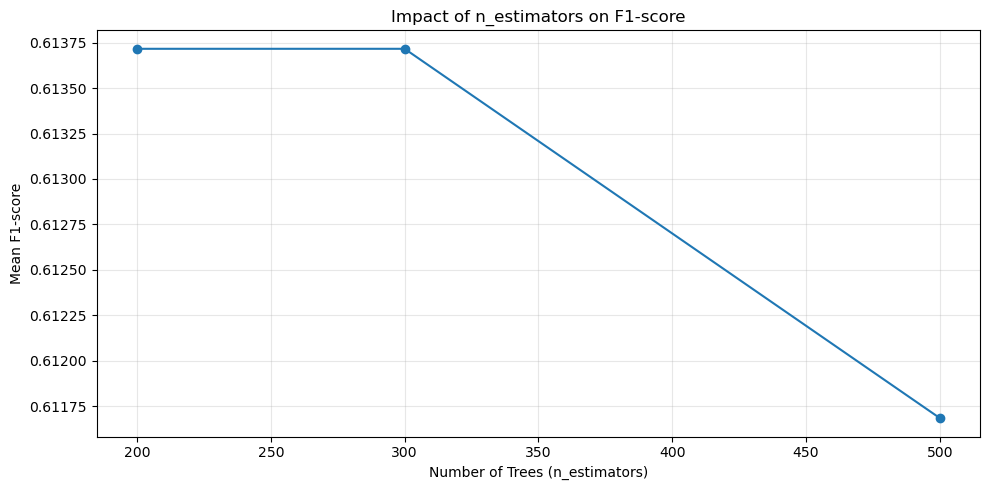

In [49]:
plt.figure(figsize=(10, 5))

df_rf_results.groupby("n_estimators")["F1-score"].mean().plot(marker="o")

plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Mean F1-score")
plt.title("Impact of n_estimators on F1-score")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [57]:
#Enreinement du modèle final avec les meilleurs hyperparamètres
rf_best = RandomForestClassifier(
    n_estimators=int(best_model["n_estimators"]),
    max_depth=None if pd.isna(best_model["max_depth"]) else int(best_model["max_depth"]),
    min_samples_leaf=int(best_model["min_samples_leaf"]),
    min_samples_split=int(best_model["min_samples_split"]),
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_best.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [59]:
import joblib

# =========================
# Sauvegarde du modèle
# =========================
model_path = "models/random_forest_best.joblib"
joblib.dump(rf_best, model_path)

print(f"✅ Modèle RandomForest sauvegardé : {model_path}")

✅ Modèle RandomForest sauvegardé : models/random_forest_best.joblib


In [60]:
scaler_path = "models/standard_scaler.joblib"
joblib.dump(scaler, scaler_path)

print(f"✅ StandardScaler sauvegardé : {scaler_path}")


✅ StandardScaler sauvegardé : models/standard_scaler.joblib


In [51]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


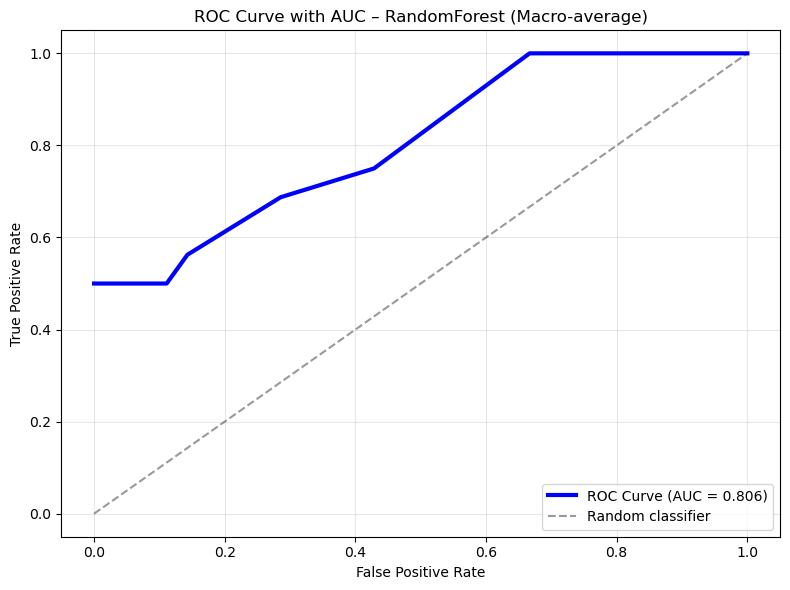

In [ ]:
# =========================
# ROC–AUC MACRO (MULTI-CLASSES) – RANDOM FOREST
# =========================

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# =========================
# 1. RECRÉATION DU MEILLEUR RANDOM FOREST
# =========================
rf_best = RandomForestClassifier(
    n_estimators=int(best_model["n_estimators"]),
    max_depth=None if pd.isna(best_model["max_depth"]) else int(best_model["max_depth"]),
    min_samples_leaf=int(best_model["min_samples_leaf"]),
    min_samples_split=int(best_model["min_samples_split"]),
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_best.fit(X_train, y_train)

# =========================
# 2. PRÉDICTIONS PROBABILISTES
# =========================
y_score = rf_best.predict_proba(X_test)

# Classes du modèle
classes = rf_best.classes_

# Binarisation des labels
y_test_bin = label_binarize(y_test, classes=classes)

# =========================
# 3. COURBE ROC MACRO-AVERAGE
# =========================
fpr = {}
tpr = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])

# Grille FPR commune
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

# Moyenne des TPR interpolées
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= len(classes)

# AUC macro
roc_auc_macro = auc(all_fpr, mean_tpr)

# =========================
# 4. PLOT ROC vs AUC
# =========================
plt.figure(figsize=(8, 6))

plt.plot(
    all_fpr,
    mean_tpr,
    color="blue",
    lw=3,
    label=f"ROC Curve (AUC = {roc_auc_macro:.3f})"
)

# Diagonale hasard
plt.plot([0, 1], [0, 1], "k--", alpha=0.4, label="Random classifier")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with AUC – RandomForest (Macro-average)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [62]:
import pandas as pd
import joblib

# =========================
# 1. PATHS
# =========================
data_path = r"C:\Users\harri\Downloads\Projet_CV_ML\Projet_CV_ML\data\processed\dataset_cv_preprocessed.xlsx"
model_path = "models/random_forest_best.joblib"
scaler_path = "models/standard_scaler.joblib"

# =========================
# 2. CHARGEMENT
# =========================
rf_model = joblib.load(model_path)
scaler = joblib.load(scaler_path)

print("✅ Modèle et scaler chargés")

# =========================
# 3. CHARGEMENT DES DONNÉES
# =========================
df_new = pd.read_excel(data_path)

print(f"📊 Dataset chargé : {df_new.shape}")
display(df_new.head())

# =========================
# 4. SÉLECTION DES FEATURES (STRICTE)
# =========================
# ⚠️ doit être IDENTIQUE à l'entraînement
features = [
    f for f in [
        'Mots',
        'Compétences',
        'Nb_Langues',
        'Nb_Comp_Tech',
        'Ratio_Tech',
        'Niveau_Diplome',
        'A_Email',
        'A_Telephone',
        'A_Permis'
    ] if f in df_new.columns
]

X_new = df_new[features].fillna(0)

print(f"✅ Features utilisées ({len(features)}): {features}")

# =========================
# 5. NORMALISATION (OBLIGATOIRE)
# =========================
X_new_scaled = scaler.transform(X_new)

# =========================
# 6. PRÉDICTIONS
# =========================
y_pred = rf_model.predict(X_new_scaled)
y_proba = rf_model.predict_proba(X_new_scaled)

# =========================
# 7. RÉSULTATS
# =========================
df_results = df_new.copy()
df_results["Prediction_Secteur"] = y_pred

# Ajout des probabilités par classe
for i, cls in enumerate(rf_model.classes_):
    df_results[f"Proba_{cls}"] = y_proba[:, i]

display(df_results.head())


✅ Modèle et scaler chargés
📊 Dataset chargé : (54, 21)


,ID,CV,Email,Téléphone,Code_Postal,Permis,Diplôme,Langues,Secteur_Activité,Mots,...,Liste_Compétences,Departement,Ratio_Comp_Mots,Densite_Competences,A_Email,A_Telephone,A_Permis,Nb_Langues,Nb_Comp_Tech,Categorie_Longueur
0,2,CV10.pdf,Non trouvé,0668114063,93600.0,Non,Master,Anglais; Français,Informatique/Tech,494.0,...,r; scikit; scikit-learn; gestion; machine lear...,93,0.014141,1.417004,0,1,0,2,1,Moyen
1,4,CV12.pdf,Melvine.moubeyi@aivancity.education,0758328589,94230.0,Non,Bachelor,Anglais; Français,Informatique/Tech,398.0,...,nlp; gcp; pandas; machine learning; français; ...,94,0.060150,6.030151,1,1,0,2,4,Moyen
2,5,CV13.pdf,Non trouvé,+33779457896,94200.0,Non,Master,Anglais; Français,Informatique/Tech,340.0,...,matplotlib; seaborn; r; tensorflow; css; scipy...,94,0.049853,5.000000,0,1,0,2,5,Moyen
3,6,CV14.pdf,mouketoudielowen@gmail.com,0619412532,94200.0,Permis A; Permis D,Baccalauréat,Anglais; Français,Informatique/Tech,554.0,...,etl; pytorch; hadoop; nlp; aws; office; spark;...,94,0.064865,6.498195,1,1,1,2,9,Moyen
4,7,CV15.pdf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Inconnu,0.000000,0.000000,1,1,1,1,0,Court


✅ Features utilisées (7): ['Mots', 'Compétences', 'Nb_Langues', 'Nb_Comp_Tech', 'A_Email', 'A_Telephone', 'A_Permis']


,ID,CV,Email,Téléphone,Code_Postal,Permis,Diplôme,Langues,Secteur_Activité,Mots,...,A_Telephone,A_Permis,Nb_Langues,Nb_Comp_Tech,Categorie_Longueur,Prediction_Secteur,Proba_Business,Proba_Industrie,Proba_Services,Proba_Tech
0,2,CV10.pdf,Non trouvé,0668114063,93600.0,Non,Master,Anglais; Français,Informatique/Tech,494.0,...,1,0,2,1,Moyen,Services,0.179190,0.115782,0.398569,0.306459
1,4,CV12.pdf,Melvine.moubeyi@aivancity.education,0758328589,94230.0,Non,Bachelor,Anglais; Français,Informatique/Tech,398.0,...,1,0,2,4,Moyen,Tech,0.040176,0.007106,0.048199,0.904519
2,5,CV13.pdf,Non trouvé,+33779457896,94200.0,Non,Master,Anglais; Français,Informatique/Tech,340.0,...,1,0,2,5,Moyen,Tech,0.075750,0.026690,0.146741,0.750819
3,6,CV14.pdf,mouketoudielowen@gmail.com,0619412532,94200.0,Permis A; Permis D,Baccalauréat,Anglais; Français,Informatique/Tech,554.0,...,1,1,2,9,Moyen,Tech,0.024165,0.017597,0.009812,0.948426
4,7,CV15.pdf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,0,Court,Industrie,0.212441,0.609213,0.141704,0.036642


In [66]:
import fitz  # PyMuPDF
import cv2
import pandas as pd
from pathlib import Path

# --------------------------------------------------
# PATHS
# --------------------------------------------------
EXCEL_PATH = Path(r"C:\Users\harri\Downloads\Projet_CV_ML\Projet_CV_ML\data\processed\dataset_cv_clean.xlsx")
CV_BASE_PATH = Path(r"C:\Users\harri\Downloads\Projet_CV_ML\Projet_CV_ML\data\raw\_Projet_CV")
PHOTO_DIR = Path(r"C:\Users\harri\Downloads\Projet_CV_ML\Projet_CV_ML\data\processed\photos")

PHOTO_DIR.mkdir(parents=True, exist_ok=True)

# --------------------------------------------------
# LOAD DATA
# --------------------------------------------------
df = pd.read_excel(EXCEL_PATH)

# Ajouter colonne Photo si absente
if "Photo" not in df.columns:
    df["Photo"] = None

# Charger détecteur visage
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

# --------------------------------------------------
# MAIN LOOP
# --------------------------------------------------
for idx, row in df.iterrows():
    cv_name = row["CV"]
    if pd.isna(cv_name):
        continue

    cv_path = CV_BASE_PATH / cv_name
    if not cv_path.exists():
        continue

    try:
        pdf = fitz.open(cv_path)

        found_photo = False

        for page_index in range(len(pdf)):
            page = pdf[page_index]
            images = page.get_images(full=True)

            for img_index, img in enumerate(images):
                xref = img[0]
                base_image = pdf.extract_image(xref)
                image_bytes = base_image["image"]

                img_array = cv2.imdecode(
                    np.frombuffer(image_bytes, dtype="uint8"),
                    cv2.IMREAD_COLOR
                )

                if img_array is None:
                    continue

                gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(gray, 1.2, 5)

                if len(faces) > 0:
                    photo_path = PHOTO_DIR / f"photo_ID_{row['ID']}.jpg"
                    cv2.imwrite(str(photo_path), img_array)

                    df.at[idx, "Photo"] = str(photo_path)
                    found_photo = True
                    break

            if found_photo:
                break

        pdf.close()

    except Exception as e:
        print(f"Erreur CV {cv_name} :", e)

# --------------------------------------------------
# SAVE UPDATED FILE
# --------------------------------------------------
df.to_excel(EXCEL_PATH, index=False)
print("✅ Extraction terminée avec succès")


✅ Extraction terminée avec succès
